In [ ]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rxnmapper import RXNMapper, BatchedMapper
import numpy as np
import pandas as pd
import amat_utils

import sys

import pprint

# dictionary key: SMILES, value: Mol object
mols_dict = {}

# rxns_AZF_example
rxns = ["CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(OCC)=O)C(C)=CC=C1.NC1=CC=C(C2=NOC=N2)C=C1>>CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(NC3=CC=C(C4=NOC=N4)C=C3)=O)C(C)=CC=C1",
        "CC1=C(NCC(OCC)=O)C(C)=CC=C1.O=C(Cl)C1CCS(CC1)(=O)=O>>CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(OCC)=O)C(C)=CC=C1",
        ] # the order of the rxns matters bc I want to record the mol_object into mols_dict


batch_size_for_RXNmapper = len(rxns)
for rxn in rxns:
    print(rxn)
    reacts_str, prods_str = rxn.split(">>")
    reacts_list = reacts_str.split(".")
    prod_list = prods_str.split(".")

    # recording all smiles in the reaction as dictionary key, whether in reactants or products.
    for smi in reacts_list + prod_list:
        if smi not in mols_dict:
            mols_dict[smi] = ""

rxn_mapper = BatchedMapper(batch_size=batch_size_for_RXNmapper)
# results = rxn_mapper.get_attention_guided_atom_maps(rxns)
batch_results = list(rxn_mapper.map_reactions(rxns))  # results as strings directly


"""
Use the first rxnmapper mapping results to remap the atom step by step (backward)
"""

for i, result in enumerate(batch_results):
    if i == 0: # stands for the very first retro step - break down the target product.
        # print("rxn #",i, result)
        # for the SMARTS string, it has to go through below two steps so that the AtomMapNum generated by rxnmapper can be recognized by RDKit
        rxn = rdChemReactions.ReactionFromSmarts(result)
        trxn = rdChemReactions.ChemicalReaction(rxn)

        rxn_smiles = rxns[i] # cautions: this is calling a variable defined eariler - rxns

        reacts_str, prods_str = rxn_smiles.split(">>")
        reacts_list = reacts_str.split(".")
        prod_list = prods_str.split(".")
    

        # this will be the target product as the final reaction is fixed at the first line in rxn. 
        for m, smi in zip(trxn.GetProducts(),prod_list):
            # print("product")
            # print([atom.GetAtomMapNum() for atom in m.GetAtoms() if not atom.GetAtomMapNum()])
            mols_dict[smi] = m
            total_atom_num = m.GetNumAtoms()
            # print("product", total_atom_num, smi, m)

        index_defined = total_atom_num +1
        # print("Starting index for unmapped atoms in reactants:", index_defined)
        for m, smi in zip(trxn.GetReactants(),reacts_list):
            # label the atom that is unmapped and connect to a mapped atom.
            # in the case that ummapped atom is only connected to unmapped atom(s), no need to label it.
            # print("reactant",smi)
            mapping_nums = [atom.GetAtomMapNum() for atom in m.GetAtoms()]
            # print("mapping of the mol (before):", mapping_nums)
            # print([atom.GetAtomMapNum() for atom in m.GetAtoms() if not atom.GetAtomMapNum()])
            if mapping_nums.count(0) == 0:  # if all atoms are mapped
                mols_dict[smi] = m
            else: # not all atoms are mapped
                # identify which atom is not mapped and give it a new mapping number then store the mol object in the dict.
                atom_to_be_mapped = []
                for atom in m.GetAtoms():
                    if atom.GetAtomMapNum() == 0:
                        # print("ummapped atom:", atom.GetAtomMapNum(), atom.GetSymbol()) # print out that the unmapped atom is truly 0 and its Symbol    
                        neighbor_mapnums = [n.GetAtomMapNum() for n in atom.GetNeighbors()] # get the mapping numbers of its neighbors
                        # print("neighbor_mapnums:",neighbor_mapnums)
                        if sum(neighbor_mapnums) > 0:  # if it is connected to a mapped atom
                            # record this atom first and set its AtomMapNum later outside the loop
                            atom_to_be_mapped.append(atom.GetIdx())
                for a in atom_to_be_mapped: # for future, the index_defined is the atom mapped number need to be appended in matrix.
                    # print("setting atom index:", a, index_defined)
                    atom = m.GetAtomWithIdx(a)
                    atom.SetAtomMapNum(index_defined)
                    index_defined += 1 # cautions: this variable will be used later, find a way to better clear out the whole script.
                # print("mapping of the mol (after):", [atom.GetAtomMapNum() for atom in m.GetAtoms()])
                mols_dict[smi] = m
    else:
        # print(f"confirm the current index: {index_defined}")
        # print("rxn #",i, result)
        rxn = rdChemReactions.ReactionFromSmarts(result)
        trxn = rdChemReactions.ChemicalReaction(rxn)

        rxn_smiles = rxns[i] # cautions: this is calling a variable defined eariler - rxns

        reacts_str, prods_str = rxn_smiles.split(">>")
        reacts_list = reacts_str.split(".")
        prod_list = prods_str.split(".")
    
        for m, smi in zip(trxn.GetReactants(),reacts_list):
            # label the atom that is unmapped and connect to a mapped atom.
            # in the case that ummapped atom is only connected to unmapped atom(s), no need to label it.
            # print("reactant",smi)
            mapping_nums = [atom.GetAtomMapNum() for atom in m.GetAtoms()]
            # print("mapping of the mol (before):", mapping_nums)
            if mapping_nums.count(0) == 0:  # if all atoms are mapped
                mols_dict[smi] = m
                # print("atom for this reatant all labled")
            else: # not all atoms are mapped
                # identify which atom is not mapped and give it a new mapping number then store the mol object in the dict.
                atom_to_be_mapped = []
                for atom in m.GetAtoms():
                    if atom.GetAtomMapNum() == 0:
                        # print("ummapped atom:", atom.GetAtomMapNum(), atom.GetSymbol()) # print out that the unmapped atom is truly 0 and its Symbol    
                        neighbor_mapnums = [n.GetAtomMapNum() for n in atom.GetNeighbors()] # get the mapping numbers of its neighbors
                        # print("neighbor_mapnums:",neighbor_mapnums)
                        if sum(neighbor_mapnums) > 0:  # if it is connected to a mapped atom
                            # record this atom first and set its AtomMapNum later outside the loop
                            atom_to_be_mapped.append(atom.GetIdx())
                for a in atom_to_be_mapped: # for future, the index_defined is the atom mapped number need to be appended in matrix.
                    # print("setting atom index:", a, index_defined)
                    atom = m.GetAtomWithIdx(a)
                    atom.SetAtomMapNum(index_defined)
                    index_defined += 1 # cautions: this variable will be used later, find a way to better clear out the whole script.
                # print("mapping of the mol (after):", [atom.GetAtomMapNum() for atom in m.GetAtoms()])
                mols_dict[smi] = m

        # for swaping mapped atom number
        # current setting is, key --> atom index, value --> [RXNmapperNum, atom symbol, mappedNum from mols_dict]
        swap_mapped_check = {}
        # Simplify the process later. swap_mapped: key --> RXNmapperNum, value --> mappedNum from mols_dict
        swap_mapped = {}
        # this will be the reactant(s) of the final reaction (1st line of rxns). 
        for m, smi in zip(trxn.GetProducts(), prod_list):
            # print("product")
            # print("Atom index:", [atom.GetIdx() for atom in m.GetAtoms()])
            # print("Atom mapped by RXN:", [atom.GetAtomMapNum() for atom in m.GetAtoms()])
            for atom in m.GetAtoms():
                swap_mapped_check[atom.GetIdx()] = [atom.GetAtomMapNum(), atom.GetSymbol()] # record the RXNmapping by atom index, get the symbol for double check
                swap_mapped[atom.GetAtomMapNum()] = atom.GetIdx()
            # pprint.pp(swap_mapped)
            # print('compare with mol stored in mols_dict:\n', 'Atom index from mols_dict', [atom.GetIdx() for atom in mols_dict[smi].GetAtoms()])
            # print("Atom mapped from mols_dict", [atom.GetAtomMapNum() for atom in mols_dict[smi].GetAtoms()])

            inverse_swap_mapped = {v: k for k, v in swap_mapped.items()} # key --> index, value --> atom map number

            for atom in mols_dict[smi].GetAtoms():
                if swap_mapped_check[atom.GetIdx()][1] == atom.GetSymbol(): # suppose the atom idx will be the same
                    swap_mapped_check[atom.GetIdx()].append(atom.GetAtomMapNum())

                    # the value of inverse_swap_mapped[atom.GetIdx()] is the atom map number
                    swap_mapped[inverse_swap_mapped[atom.GetIdx()]] = atom.GetAtomMapNum()
                    # Use this swap_mapped, implement the mappedNum from mols_dict to reactents from the current rxn.
                    
                else:
                    raise "Warning: Atom index not match."
            with open("check_inverse.txt", "w") as file:
                file.write("key is atom index, value is a list of [RXNmapperNum, atom symbol, mappedNum from mols_dict]\n")
                pprint.pprint(swap_mapped_check, stream=file)
                file.write("key is RXNmapperNum, value is mappedNum from mols_dict\n")
                pprint.pprint(swap_mapped, stream=file)

        """
        IMPORTANT here: swap the atom mapping number
        """
        # swap prod mapping of the next rxn first:
        for m_RXN, smi in zip(trxn.GetProducts(), prod_list):
            mol_in_dict = mols_dict[smi]
            for atom in m_RXN.GetAtoms():
                if atom.GetAtomMapNum() in swap_mapped:
                    atom.SetAtomMapNum(swap_mapped[atom.GetAtomMapNum()])
        for m_RXN, smi in zip(trxn.GetReactants(),reacts_list):
            mol_in_dict = mols_dict[smi]
            for atom in m_RXN.GetAtoms():
                if atom.GetAtomMapNum() in swap_mapped:
                    atom.SetAtomMapNum(swap_mapped[atom.GetAtomMapNum()])

mols_to_draw = []
for item in mols_dict:
    mols_to_draw.append(mols_dict[item])

Draw.MolsToGridImage(mols_to_draw, subImgSize=(350, 350)) # This seems to work!!


# scripts generated with Copilate's help

def _bonds_from_template(template_mol, kekulize=False):
    """
    Extract bonds between mapped atoms from a template molecule.
    Returns: dict {(atom1_mapNum, atom2_mapNum): rdkit.Chem.rdchem.BondType}
    """
    # work on a copy to optionally kekulize safely

    copy_mol = Chem.Mol(template_mol)

    if kekulize:
        try:
            Chem.Kekulize(copy_mol, clearAromaticFlags=True)
        except Exception:
            # fallback if kekulization fails; just keep as is
            pass

    idx_to_map = {}
    for a in copy_mol.GetAtoms():
        m = a.GetAtomMapNum()
        if m:  # >0 means mapped, since we don't really care the unmapped atoms (neglected in matrix)
            idx_to_map[a.GetIdx()] = m

    edge2type = {}
    for b in copy_mol.GetBonds():
        a1, a2 = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        if a1 in idx_to_map and a2 in idx_to_map:
            i, j = sorted((idx_to_map[a1], idx_to_map[a2])) # record the bond mapping number instead of the atom index
            edge2type[(i, j)] = b.GetBondType()
    return edge2type


def summarize_bond_changes(rxn, kekulize=False):
    """
    Given an rdChemReactions.ChemicalReaction, report which bonds are formed,
    broken, or change order, based on template differences.
    """
    # union across all reactant templates
    r_edge2type = {}
    for i in range(rxn.GetNumReactantTemplates()):
        tmpl = rxn.GetReactantTemplate(i) #rdkit.Chem.rdchem.Mol object
        r_edge2type.update(_bonds_from_template(tmpl, kekulize=kekulize))

    # union across all product templates
    p_edge2type = {}
    # print(rxn.GetNumProductTemplates())
    for i in range(rxn.GetNumProductTemplates()):
        tmpl = rxn.GetProductTemplate(i) #rdkit.Chem.rdchem.Mol object
        p_edge2type.update(_bonds_from_template(tmpl, kekulize=kekulize))

    # print(r_edge2type)

    r_edges = set(r_edge2type)
    p_edges = set(p_edge2type)

    # print(r_edges)
    # print(p_edges)

    broken = sorted(r_edges - p_edges)              # present only in reactants
    formed = sorted(p_edges - r_edges)              # present only in products
    common = r_edges & p_edges


    order_changes = [
        (e, r_edge2type[e], p_edge2type[e])
        for e in sorted(common)
        if r_edge2type[e] != p_edge2type[e]
    ]

    return {
        "broken": [(e, r_edge2type[e]) for e in broken],
        "formed": [(e, p_edge2type[e]) for e in formed],
        "order_changes": order_changes,
    }
# redefine the rxns with the proper atom mapping
rxns_remapped = []
for rxn in rxns:
    rxn_remapped = ""
    reacts_str, prods_str = rxn.split(">>")
    reacts_list = reacts_str.split(".")
    prod_list = prods_str.split(".")
    for react in reacts_list:
        # print(mols_dict[react])
        # print(Chem.MolToSmarts(mols_dict[react]))
        rxn_remapped = rxn_remapped + Chem.MolToSmarts(mols_dict[react]) + "."
    
    # add the >> and remove the extra dot
    rxn_remapped = rxn_remapped[:-1] + ">>"
    print("quick check", rxn_remapped)

    for prod in prod_list:
        rxn_remapped = rxn_remapped + Chem.MolToSmarts(mols_dict[prod]) + "."

    # remove the extra dot
    rxn_remapped = rxn_remapped[:-1]
    print("quick check", rxn_remapped)

    rxns_remapped.append(rxn_remapped)

    
target_SMARTS = rxns_remapped[0].split('>>')[1]

target = Chem.MolFromSmarts(target_SMARTS)
amat = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)
amat_init = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)

target_atoms = [atm.GetAtomicNum() for atm in target.GetAtoms()]
target_symbs = [atm.GetSymbol() for atm in target.GetAtoms()]

# this step comes here so no trouble in looping reactants in later stage
reactants = []
for rxn_mapped in rxns_remapped:
    reacts = rxn_mapped.split('>>')[0]
    reactants += reacts.split('.')

product_total_atoms = len(amat_init)
pad_info = {} # this record what atom (Mapped number and the atomic number) should be added later to the changelogs.

for reactant_smarts in reactants:
    mol = Chem.MolFromSmarts(reactant_smarts)
    for a in mol.GetAtoms():
        if a.GetAtomMapNum() > product_total_atoms:
            pad_info[a.GetAtomMapNum()] = a.GetAtomicNum()


changelogs=[] # come later

Chiral_flag = {} # {chiral_atom : 0}

# step 1: need to do the stereo in final target
first_log = {'pad': None, 'pad_elem':[], 'edits':[]}
for a in target.GetAtoms(): # should be only one product in the final reaction, careful that this is calling the variable defined earlier - target
    if a.GetChiralTag() != 0:
        # print('atom MAP number:', a.GetAtomMapNum(), 'atom index:', a.GetIdx())
        first_log['edits'].append((a.GetAtomMapNum(), a.GetAtomMapNum(), 1)) # this will always be 1 as it's stereo
        Chiral_flag[a.GetAtomMapNum()] = 1
        # here I consider Chiral atom only, there is another stereo but goes on bond (i.e. get bonds first then do the .GetStereo() to the bond object)

first_log['pad'] = 0


# reverse it first due to Chiral center duplication issue
for rxn_smarts in reversed(rxns_remapped):
    rxn_obj = rdChemReactions.ReactionFromSmarts(rxn_smarts)
    rxn_again = rdChemReactions.ChemicalReaction(rxn_obj)
    bond_changes = summarize_bond_changes(rxn_obj)

    log = {'pad': None, 'pad_elem':[], 'edits':[]}

    # step 2: now, start recoding the reaction change
    # reset the log
    # ALERT: pad_elem sequence does MATTER!!!, eariler it shows will have lower Atom Mapping number.
    if len(rxn_again.GetProducts()) == 1:
        intermediate_p = rxn_again.GetProducts()[0]
    for a in intermediate_p.GetAtoms():
        if a.GetChiralTag() != 0:
            if Chiral_flag.get(a.GetAtomMapNum(), 0) == 0:
                pass
            else:
                # print('atom MAP number:', a.GetAtomMapNum(), 'atom index:', a.GetIdx())
                log['edits'].append((a.GetAtomMapNum(), a.GetAtomMapNum(), -1)) # this will always be 1 as it's stereo
                Chiral_flag[a.GetAtomMapNum()] -= 1 # take 1 off

    new_pad_record = set()
    if bond_changes["formed"] == []:
        pass
    else:
        for bond_formation in bond_changes["formed"]:
            new_pad_record.add(bond_formation[0][0]) # record the atom mapping number now, sort out the set later to check which atom need to be padded
            new_pad_record.add(bond_formation[0][1])

            if bond_formation[1] == Chem.rdchem.BondType.SINGLE:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -1))
            elif bond_formation[1] == Chem.rdchem.BondType.DOUBLE:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -2))
            elif bond_formation[1] == Chem.rdchem.BondType.TRIPLE:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -3))
            elif bond_formation[1] == Chem.rdchem.BondType.AROMATIC:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -1.5))
            elif bond_formation[1] == Chem.rdchem.BondType.QUADRUPLE:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -4))
            else:
                raise "Warning: new bond type not recorded."
    
    if bond_changes["broken"] == []:
        pass
    else:    
        for bond_broken in bond_changes["broken"]:
            new_pad_record.add(bond_broken[0][0])
            new_pad_record.add(bond_broken[0][1])

            if bond_broken[1] == Chem.rdchem.BondType.SINGLE:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 1))
            elif bond_broken[1] == Chem.rdchem.BondType.DOUBLE:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 2))
            elif bond_broken[1] == Chem.rdchem.BondType.TRIPLE:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 3))
            elif bond_broken[1] == Chem.rdchem.BondType.AROMATIC:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 1.5))
            elif bond_broken[1] == Chem.rdchem.BondType.QUADRUPLE:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 4))
            else:
                raise "Warning: broken bond type not recorded."

    # if bond_changes["order_changes"] == []:
    #     pass
    # else:
    #     for order_change in bond_changes["order_changes"]:
    #         new_pad_record = new_pad_record + (order_change[0][0], order_change[0][1])
            
    #         if #TODO: the tuple should look like ((atom1, atom2), react_bondtype, prod_bondtype)
    #         # so I should record change = prod_bondtype - react_bondtype to log['edits].append((atom1, atom2, change))
        

    for mapped_a in new_pad_record:
        if mapped_a > product_total_atoms:
            log['pad_elem'].append(pad_info[mapped_a]) # what is the atomic number of the atom needed to be padded? use pad_info
        else:
            pass

    log['pad'] = len(log['pad_elem']) # how many new atom need to pad into the amat
        

    changelogs.append(log)


if any(value != 0 for value in Chiral_flag.values()):
    raise ValueError("Warning: One or more flags are not set to 0.")


changelogs = [first_log] + changelogs[::-1] # reverse the changelogs order so that it is in the forward direction


pprint.pprint(changelogs)






In [1]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rxnmapper import RXNMapper, BatchedMapper
import numpy as np
import pandas as pd
import amat_utils

import sys

import pprint

c:\Users\U1093432\OneDrive - Sanofi\Documents\Projects\.venv_graph_edit\Lib\site-packages\rxnmapper\batched_mapper.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# dictionary key: SMILES, value: Mol object
mols_dict = {}

#### Careful in the order as that matters. From "more-close-to-target-product" to "precursors".

In [3]:
# # rxns_AZF_example
# rxns = ["CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(OCC)=O)C(C)=CC=C1.NC1=CC=C(C2=NOC=N2)C=C1>>CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(NC3=CC=C(C4=NOC=N4)C=C3)=O)C(C)=CC=C1",
#         "CC1=C(NCC(OCC)=O)C(C)=CC=C1.O=C(Cl)C1CCS(CC1)(=O)=O>>CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(OCC)=O)C(C)=CC=C1",
#         ] # the order of the rxns matters bc I want to record the mol_object into mols_dict
# rxns = ["CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(OCC)=O)C(C)=CC=C1.NC1=CC=C(C2=NOC=N2)C=C1>>CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(NC3=CC=C(C4=NOC=N4)C=C3)=O)C(C)=CC=C1"] 

# the easy molecule example from Alan's file
rxns = [
    'NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCNC5.ClC(/C(C#N)=C/C(C)(C)C)=O>>NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCN(C(/C(C#N)=C/C(C)(C)C)=O)C5',
    'NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCN(C5)C(OC(C)(C)C)=O>>NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCNC5',
    'NC1=NC=NC2=C1C(Br)=NN2[C@@H]3CCCN(C3)C(OC(C)(C)C)=O.FC1=C(B(O)O)C=CC(OC2=CC=CC=C2)=C1>>NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCN(C5)C(OC(C)(C)C)=O',
    'NC1=NC=NC2=C1C(Br)=NN2.O[C@H]1CCCN(C1)C(OC(C)(C)C)=O>>NC1=NC=NC2=C1C(Br)=NN2[C@@H]3CCCN(C3)C(OC(C)(C)C)=O',
]

In [4]:
batch_size_for_RXNmapper = len(rxns)
for rxn in rxns:
    print(rxn)
    reacts_str, prods_str = rxn.split(">>")
    reacts_list = reacts_str.split(".")
    prod_list = prods_str.split(".")

    # recording all smiles in the reaction as dictionary key, whether in reactants or products.
    for smi in reacts_list + prod_list:
        if smi not in mols_dict:
            mols_dict[smi] = ""



print(len(mols_dict))  # should be 5 unique molecules for AZF's example, and 8 for case easy molecule example

NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCNC5.ClC(/C(C#N)=C/C(C)(C)C)=O>>NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCN(C(/C(C#N)=C/C(C)(C)C)=O)C5
NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCN(C5)C(OC(C)(C)C)=O>>NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCNC5
NC1=NC=NC2=C1C(Br)=NN2[C@@H]3CCCN(C3)C(OC(C)(C)C)=O.FC1=C(B(O)O)C=CC(OC2=CC=CC=C2)=C1>>NC1=NC=NC2=C1C(C3=C(F)C=C(OC4=CC=CC=C4)C=C3)=NN2[C@@H]5CCCN(C5)C(OC(C)(C)C)=O
NC1=NC=NC2=C1C(Br)=NN2.O[C@H]1CCCN(C1)C(OC(C)(C)C)=O>>NC1=NC=NC2=C1C(Br)=NN2[C@@H]3CCCN(C3)C(OC(C)(C)C)=O
8


In [5]:
rxn_mapper = BatchedMapper(batch_size=batch_size_for_RXNmapper)
# results = rxn_mapper.get_attention_guided_atom_maps(rxns)
batch_results = list(rxn_mapper.map_reactions(rxns))  # results as strings directly


In [6]:
batch_results

['[NH2:1][C:2]1=[N:3][CH:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[CH:12]=[C:13]([O:14][C:15]3=[CH:16][CH:17]=[CH:18][CH:19]=[CH:20]3)[CH:21]=[CH:22]1)=[N:23][N:24]2[C@@H:25]1[CH2:26][CH2:27][CH2:28][NH:29][CH2:40]1.Cl[C:30](/[C:31]([C:32]#[N:33])=[CH:34]/[C:35]([CH3:36])([CH3:37])[CH3:38])=[O:39]>>[NH2:1][C:2]1=[N:3][CH:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[CH:12]=[C:13]([O:14][C:15]3=[CH:16][CH:17]=[CH:18][CH:19]=[CH:20]3)[CH:21]=[CH:22]1)=[N:23][N:24]2[C@@H:25]1[CH2:26][CH2:27][CH2:28][N:29]([C:30](/[C:31]([C:32]#[N:33])=[CH:34]/[C:35]([CH3:36])([CH3:37])[CH3:38])=[O:39])[CH2:40]1',
 '[NH2:1][C:2]1=[N:3][CH:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[CH:12]=[C:13]([O:14][C:15]3=[CH:16][CH:17]=[CH:18][CH:19]=[CH:20]3)[CH:21]=[CH:22]1)=[N:23][N:24]2[C@@H:25]1[CH2:26][CH2:27][CH2:28][N:29](C(OC(C)(C)C)=O)[CH2:30]1>>[NH2:1][C:2]1=[N:3][CH:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[CH:12]=[C:13]([O:14][C:15]3=[CH:16][CH:17]=[CH:18][CH:19]=[CH:20]3)[CH:21]=[CH

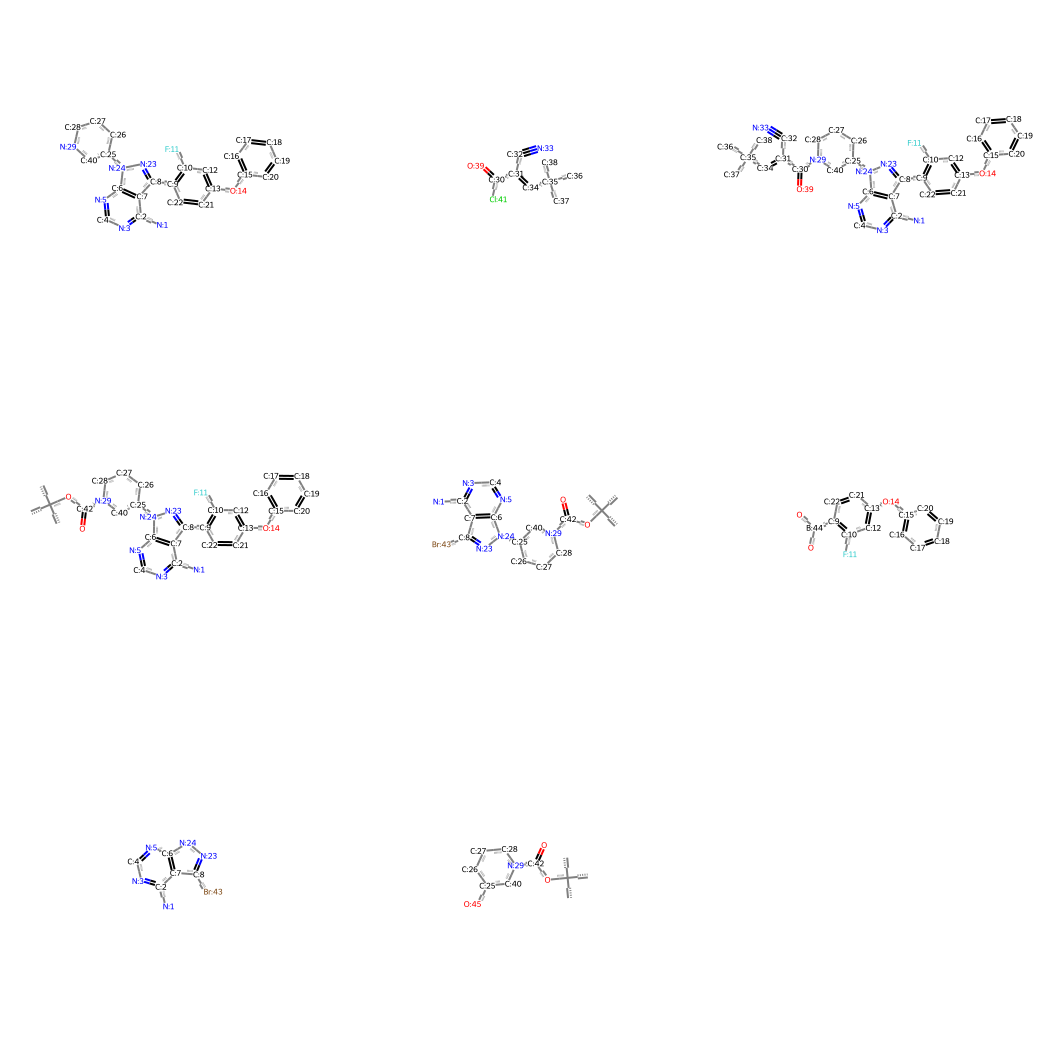

In [7]:
"""
Use the first rxnmapper mapping results to remap the atom step by step (backward)
"""

for i, result in enumerate(batch_results):
    if i == 0: # stands for the very first retro step - break down the target product.
        # print("rxn #",i, result)
        # for the SMARTS string, it has to go through below two steps so that the AtomMapNum generated by rxnmapper can be recognized by RDKit
        rxn = rdChemReactions.ReactionFromSmarts(result)
        trxn = rdChemReactions.ChemicalReaction(rxn)

        rxn_smiles = rxns[i] # cautions: this is calling a variable defined eariler - rxns

        reacts_str, prods_str = rxn_smiles.split(">>")
        reacts_list = reacts_str.split(".")
        prod_list = prods_str.split(".")
    

        # this will be the target product as the final reaction is fixed at the first line in rxn. 
        for m, smi in zip(trxn.GetProducts(),prod_list):
            # print("product")
            # print([atom.GetAtomMapNum() for atom in m.GetAtoms() if not atom.GetAtomMapNum()])
            mols_dict[smi] = m
            total_atom_num = m.GetNumAtoms()
            # print("product", total_atom_num, smi, m)

        index_defined = total_atom_num +1
        # print("Starting index for unmapped atoms in reactants:", index_defined)
        for m, smi in zip(trxn.GetReactants(),reacts_list):
            # label the atom that is unmapped and connect to a mapped atom.
            # in the case that ummapped atom is only connected to unmapped atom(s), no need to label it.
            # print("reactant",smi)
            mapping_nums = [atom.GetAtomMapNum() for atom in m.GetAtoms()]
            # print("mapping of the mol (before):", mapping_nums)
            # print([atom.GetAtomMapNum() for atom in m.GetAtoms() if not atom.GetAtomMapNum()])
            if mapping_nums.count(0) == 0:  # if all atoms are mapped
                mols_dict[smi] = m
            else: # not all atoms are mapped
                # identify which atom is not mapped and give it a new mapping number then store the mol object in the dict.
                atom_to_be_mapped = []
                for atom in m.GetAtoms():
                    if atom.GetAtomMapNum() == 0:
                        # print("ummapped atom:", atom.GetAtomMapNum(), atom.GetSymbol()) # print out that the unmapped atom is truly 0 and its Symbol    
                        neighbor_mapnums = [n.GetAtomMapNum() for n in atom.GetNeighbors()] # get the mapping numbers of its neighbors
                        # print("neighbor_mapnums:",neighbor_mapnums)
                        if sum(neighbor_mapnums) > 0:  # if it is connected to a mapped atom
                            # record this atom first and set its AtomMapNum later outside the loop
                            atom_to_be_mapped.append(atom.GetIdx())
                for a in atom_to_be_mapped: # for future, the index_defined is the atom mapped number need to be appended in matrix.
                    # print("setting atom index:", a, index_defined)
                    atom = m.GetAtomWithIdx(a)
                    atom.SetAtomMapNum(index_defined)
                    index_defined += 1 # cautions: this variable will be used later, find a way to better clear out the whole script.
                # print("mapping of the mol (after):", [atom.GetAtomMapNum() for atom in m.GetAtoms()])
                mols_dict[smi] = m
    else:
        # print(f"confirm the current index: {index_defined}")
        # print("rxn #",i, result)
        rxn = rdChemReactions.ReactionFromSmarts(result)
        trxn = rdChemReactions.ChemicalReaction(rxn)

        rxn_smiles = rxns[i] # cautions: this is calling a variable defined eariler - rxns

        reacts_str, prods_str = rxn_smiles.split(">>")
        reacts_list = reacts_str.split(".")
        prod_list = prods_str.split(".")
    
        for m, smi in zip(trxn.GetReactants(),reacts_list):
            # label the atom that is unmapped and connect to a mapped atom.
            # in the case that ummapped atom is only connected to unmapped atom(s), no need to label it.
            # print("reactant",smi)
            mapping_nums = [atom.GetAtomMapNum() for atom in m.GetAtoms()]
            # print("mapping of the mol (before):", mapping_nums)
            if mapping_nums.count(0) == 0:  # if all atoms are mapped
                mols_dict[smi] = m
                # print("atom for this reatant all labled")
            else: # not all atoms are mapped
                # identify which atom is not mapped and give it a new mapping number then store the mol object in the dict.
                atom_to_be_mapped = []
                for atom in m.GetAtoms():
                    if atom.GetAtomMapNum() == 0:
                        # print("ummapped atom:", atom.GetAtomMapNum(), atom.GetSymbol()) # print out that the unmapped atom is truly 0 and its Symbol    
                        neighbor_mapnums = [n.GetAtomMapNum() for n in atom.GetNeighbors()] # get the mapping numbers of its neighbors
                        # print("neighbor_mapnums:",neighbor_mapnums)
                        if sum(neighbor_mapnums) > 0:  # if it is connected to a mapped atom
                            # record this atom first and set its AtomMapNum later outside the loop
                            atom_to_be_mapped.append(atom.GetIdx())
                for a in atom_to_be_mapped: # for future, the index_defined is the atom mapped number need to be appended in matrix.
                    # print("setting atom index:", a, index_defined)
                    atom = m.GetAtomWithIdx(a)
                    atom.SetAtomMapNum(index_defined)
                    index_defined += 1 # cautions: this variable will be used later, find a way to better clear out the whole script.
                # print("mapping of the mol (after):", [atom.GetAtomMapNum() for atom in m.GetAtoms()])
                mols_dict[smi] = m

        # for swaping mapped atom number
        # current setting is, key --> atom index, value --> [RXNmapperNum, atom symbol, mappedNum from mols_dict]
        swap_mapped_check = {}
        # Simplify the process later. swap_mapped: key --> RXNmapperNum, value --> mappedNum from mols_dict
        swap_mapped = {}
        # this will be the reactant(s) of the final reaction (1st line of rxns). 
        for m, smi in zip(trxn.GetProducts(), prod_list):
            # print("product")
            # print("Atom index:", [atom.GetIdx() for atom in m.GetAtoms()])
            # print("Atom mapped by RXN:", [atom.GetAtomMapNum() for atom in m.GetAtoms()])
            for atom in m.GetAtoms():
                swap_mapped_check[atom.GetIdx()] = [atom.GetAtomMapNum(), atom.GetSymbol()] # record the RXNmapping by atom index, get the symbol for double check
                swap_mapped[atom.GetAtomMapNum()] = atom.GetIdx()
            # pprint.pp(swap_mapped)
            # print('compare with mol stored in mols_dict:\n', 'Atom index from mols_dict', [atom.GetIdx() for atom in mols_dict[smi].GetAtoms()])
            # print("Atom mapped from mols_dict", [atom.GetAtomMapNum() for atom in mols_dict[smi].GetAtoms()])

            inverse_swap_mapped = {v: k for k, v in swap_mapped.items()} # key --> index, value --> atom map number

            for atom in mols_dict[smi].GetAtoms():
                if swap_mapped_check[atom.GetIdx()][1] == atom.GetSymbol(): # suppose the atom idx will be the same
                    swap_mapped_check[atom.GetIdx()].append(atom.GetAtomMapNum())

                    # the value of inverse_swap_mapped[atom.GetIdx()] is the atom map number
                    swap_mapped[inverse_swap_mapped[atom.GetIdx()]] = atom.GetAtomMapNum()
                    # Use this swap_mapped, implement the mappedNum from mols_dict to reactents from the current rxn.
                    
                else:
                    raise "Warning: Atom index not match."
            with open("check_inverse.txt", "w") as file:
                file.write("key is atom index, value is a list of [RXNmapperNum, atom symbol, mappedNum from mols_dict]\n")
                pprint.pprint(swap_mapped_check, stream=file)
                file.write("key is RXNmapperNum, value is mappedNum from mols_dict\n")
                pprint.pprint(swap_mapped, stream=file)

        """
        IMPORTANT here: swap the atom mapping number
        """
        # swap prod mapping of the next rxn first:
        for m_RXN, smi in zip(trxn.GetProducts(), prod_list):
            mol_in_dict = mols_dict[smi]
            for atom in m_RXN.GetAtoms():
                if atom.GetAtomMapNum() in swap_mapped:
                    atom.SetAtomMapNum(swap_mapped[atom.GetAtomMapNum()])
        for m_RXN, smi in zip(trxn.GetReactants(),reacts_list):
            mol_in_dict = mols_dict[smi]
            for atom in m_RXN.GetAtoms():
                if atom.GetAtomMapNum() in swap_mapped:
                    atom.SetAtomMapNum(swap_mapped[atom.GetAtomMapNum()])

mols_to_draw = []
for item in mols_dict:
    mols_to_draw.append(mols_dict[item])

Draw.MolsToGridImage(mols_to_draw, subImgSize=(350, 350)) # This seems to work!!


# track the bond change

In [8]:
# scripts generated with Copilate's help

def _bonds_from_template(template_mol, kekulize=False):
    """
    Extract bonds between mapped atoms from a template molecule.
    Returns: dict {(atom1_mapNum, atom2_mapNum): rdkit.Chem.rdchem.BondType}
    """
    # work on a copy to optionally kekulize safely

    copy_mol = Chem.Mol(template_mol)

    if kekulize:
        try:
            Chem.Kekulize(copy_mol, clearAromaticFlags=True)
        except Exception:
            # fallback if kekulization fails; just keep as is
            pass

    idx_to_map = {}
    for a in copy_mol.GetAtoms():
        m = a.GetAtomMapNum()
        if m:  # >0 means mapped, since we don't really care the unmapped atoms (neglected in matrix)
            idx_to_map[a.GetIdx()] = m

    edge2type = {}
    for b in copy_mol.GetBonds():
        a1, a2 = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        if a1 in idx_to_map and a2 in idx_to_map:
            i, j = sorted((idx_to_map[a1], idx_to_map[a2])) # record the bond mapping number instead of the atom index
            edge2type[(i, j)] = b.GetBondType()
    return edge2type


def summarize_bond_changes(rxn, kekulize=False):
    """
    Given an rdChemReactions.ChemicalReaction, report which bonds are formed,
    broken, or change order, based on template differences.
    """
    # union across all reactant templates
    r_edge2type = {}
    for i in range(rxn.GetNumReactantTemplates()):
        tmpl = rxn.GetReactantTemplate(i) #rdkit.Chem.rdchem.Mol object
        r_edge2type.update(_bonds_from_template(tmpl, kekulize=kekulize))

    # union across all product templates
    p_edge2type = {}
    # print(rxn.GetNumProductTemplates())
    for i in range(rxn.GetNumProductTemplates()):
        tmpl = rxn.GetProductTemplate(i) #rdkit.Chem.rdchem.Mol object
        p_edge2type.update(_bonds_from_template(tmpl, kekulize=kekulize))

    # print(r_edge2type)

    r_edges = set(r_edge2type)
    p_edges = set(p_edge2type)

    # print(r_edges)
    # print(p_edges)

    broken = sorted(r_edges - p_edges)              # present only in reactants
    formed = sorted(p_edges - r_edges)              # present only in products
    common = r_edges & p_edges


    order_changes = [
        (e, r_edge2type[e], p_edge2type[e])
        for e in sorted(common)
        if r_edge2type[e] != p_edge2type[e]
    ]

    return {
        "broken": [(e, r_edge2type[e]) for e in broken],
        "formed": [(e, p_edge2type[e]) for e in formed],
        "order_changes": order_changes,
    }


In [9]:
# redefine the rxns with the proper atom mapping
rxns_remapped = []
for rxn in rxns:
    rxn_remapped = ""
    reacts_str, prods_str = rxn.split(">>")
    reacts_list = reacts_str.split(".")
    prod_list = prods_str.split(".")
    for react in reacts_list:
        # print(mols_dict[react])
        # print(Chem.MolToSmarts(mols_dict[react]))
        rxn_remapped = rxn_remapped + Chem.MolToSmarts(mols_dict[react]) + "."
    
    # add the >> and remove the extra dot
    rxn_remapped = rxn_remapped[:-1] + ">>"
    print("quick check", rxn_remapped)

    for prod in prod_list:
        rxn_remapped = rxn_remapped + Chem.MolToSmarts(mols_dict[prod]) + "."

    # remove the extra dot
    rxn_remapped = rxn_remapped[:-1]
    print("quick check", rxn_remapped)

    rxns_remapped.append(rxn_remapped)

rxns_remapped

quick check [N&H2:1][C:2]1=[N:3][C&H1:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[C&H1:12]=[C:13]([O:14][C:15]3=[C&H1:16][C&H1:17]=[C&H1:18][C&H1:19]=[C&H1:20]3)[C&H1:21]=[C&H1:22]1)=[N:23][N:24]2[C@@&H1:25]1[C&H2:26][C&H2:27][C&H2:28][N&H1:29][C&H2:40]1.[Cl:41][C:30](/[C:31]([C:32]#[N:33])=[C&H1:34]/[C:35]([C&H3:36])([C&H3:37])[C&H3:38])=[O:39]>>
quick check [N&H2:1][C:2]1=[N:3][C&H1:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[C&H1:12]=[C:13]([O:14][C:15]3=[C&H1:16][C&H1:17]=[C&H1:18][C&H1:19]=[C&H1:20]3)[C&H1:21]=[C&H1:22]1)=[N:23][N:24]2[C@@&H1:25]1[C&H2:26][C&H2:27][C&H2:28][N&H1:29][C&H2:40]1.[Cl:41][C:30](/[C:31]([C:32]#[N:33])=[C&H1:34]/[C:35]([C&H3:36])([C&H3:37])[C&H3:38])=[O:39]>>[N&H2:1][C:2]1=[N:3][C&H1:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[C&H1:12]=[C:13]([O:14][C:15]3=[C&H1:16][C&H1:17]=[C&H1:18][C&H1:19]=[C&H1:20]3)[C&H1:21]=[C&H1:22]1)=[N:23][N:24]2[C@@&H1:25]1[C&H2:26][C&H2:27][C&H2:28][N:29]([C:30](/[C:31]([C:32]#[N:33])=[C&H1:34]/[C:35]([C&H3:36]

['[N&H2:1][C:2]1=[N:3][C&H1:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[C&H1:12]=[C:13]([O:14][C:15]3=[C&H1:16][C&H1:17]=[C&H1:18][C&H1:19]=[C&H1:20]3)[C&H1:21]=[C&H1:22]1)=[N:23][N:24]2[C@@&H1:25]1[C&H2:26][C&H2:27][C&H2:28][N&H1:29][C&H2:40]1.[Cl:41][C:30](/[C:31]([C:32]#[N:33])=[C&H1:34]/[C:35]([C&H3:36])([C&H3:37])[C&H3:38])=[O:39]>>[N&H2:1][C:2]1=[N:3][C&H1:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[C&H1:12]=[C:13]([O:14][C:15]3=[C&H1:16][C&H1:17]=[C&H1:18][C&H1:19]=[C&H1:20]3)[C&H1:21]=[C&H1:22]1)=[N:23][N:24]2[C@@&H1:25]1[C&H2:26][C&H2:27][C&H2:28][N:29]([C:30](/[C:31]([C:32]#[N:33])=[C&H1:34]/[C:35]([C&H3:36])([C&H3:37])[C&H3:38])=[O:39])[C&H2:40]1',
 '[N&H2:1][C:2]1=[N:3][C&H1:4]=[N:5][C:6]2=[C:7]1[C:8]([C:9]1=[C:10]([F:11])[C&H1:12]=[C:13]([O:14][C:15]3=[C&H1:16][C&H1:17]=[C&H1:18][C&H1:19]=[C&H1:20]3)[C&H1:21]=[C&H1:22]1)=[N:23][N:24]2[C@@&H1:25]1[C&H2:26][C&H2:27][C&H2:28][N:29]([C:42](OC(C)(C)C)=O)[C&H2:40]1>>[N&H2:1][C:2]1=[N:3][C&H1:4]=[N:5][C:6]2=[C:7]1[C:8](

The ultimate goal is to make a dictionary like this:

[{'edits': ()},
 {'pad': 0,
  'pad_elem': [],
  'edits': [(3, 3, 1), (6, 6, 1), (7, 7, 1), (8, 8, 1)]},
 {'pad': 1, 'pad_elem': [35], 'edits': [(12, 13, -1), (13, 17, 1)]}]

In [10]:
target_SMARTS = rxns_remapped[0].split('>>')[1]

target = Chem.MolFromSmarts(target_SMARTS)
amat = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)
amat_init = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)

target_atoms = [atm.GetAtomicNum() for atm in target.GetAtoms()]
target_symbs = [atm.GetSymbol() for atm in target.GetAtoms()]

amat_init

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(40, 40))

### make a pad_info dictionary for the latter pad and pad_elem use.

In [11]:
# this step comes here so no trouble in looping reactants in later stage
reactants = []
for rxn_mapped in rxns_remapped:
    reacts = rxn_mapped.split('>>')[0]
    reactants += reacts.split('.')

product_total_atoms = len(amat_init)
pad_info = {} # this record what atom (Mapped number and the atomic number) should be added later to the changelogs.

for reactant_smarts in reactants:
    mol = Chem.MolFromSmarts(reactant_smarts)
    for a in mol.GetAtoms():
        if a.GetAtomMapNum() > product_total_atoms:
            pad_info[a.GetAtomMapNum()] = a.GetAtomicNum()

pad_info

{41: 17, 42: 6, 43: 35, 44: 5, 45: 8}

In [ ]:
changelogs=[] # come later

Chiral_flag = {} # {chiral_atom : 0}

# step 1: need to do the stereo in final target
first_log = {'pad': None, 'pad_elem':[], 'edits':[]}
for a in target.GetAtoms(): # should be only one product in the final reaction, careful that this is calling the variable defined earlier - target
    if a.GetChiralTag() != 0:
        # print('atom MAP number:', a.GetAtomMapNum(), 'atom index:', a.GetIdx())
        first_log['edits'].append((a.GetAtomMapNum(), a.GetAtomMapNum(), 1)) # this will always be 1 as it's stereo
        Chiral_flag[a.GetAtomMapNum()] = 1
        # here I consider Chiral atom only, there is another stereo but goes on bond (i.e. get bonds first then do the .GetStereo() to the bond object)

first_log['pad'] = 0


# reverse it first due to Chiral center duplication issue
for rxn_smarts in reversed(rxns_remapped):
    rxn_obj = rdChemReactions.ReactionFromSmarts(rxn_smarts)
    rxn_again = rdChemReactions.ChemicalReaction(rxn_obj)
    bond_changes = summarize_bond_changes(rxn_obj)

    log = {'pad': None, 'pad_elem':[], 'edits':[]}

    # step 2: now, start recoding the reaction change
    # reset the log
    # ALERT: pad_elem sequence does MATTER!!!, eariler it shows will have lower Atom Mapping number.
    if len(rxn_again.GetProducts()) == 1:
        intermediate_p = rxn_again.GetProducts()[0]
    for a in intermediate_p.GetAtoms():
        if a.GetChiralTag() != 0:
            if Chiral_flag.get(a.GetAtomMapNum(), 0) == 0:
                pass
            else:
                # print('atom MAP number:', a.GetAtomMapNum(), 'atom index:', a.GetIdx())
                log['edits'].append((a.GetAtomMapNum(), a.GetAtomMapNum(), -1)) # this will always be 1 as it's stereo
                Chiral_flag[a.GetAtomMapNum()] -= 1 # take 1 off

    new_pad_record = set()
    if bond_changes["formed"] == []:
        pass
    else:
        for bond_formation in bond_changes["formed"]:
            new_pad_record.add(bond_formation[0][0]) # record the atom mapping number now, sort out the set later to check which atom need to be padded
            new_pad_record.add(bond_formation[0][1])

            if bond_formation[1] == Chem.rdchem.BondType.SINGLE:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -1))
            elif bond_formation[1] == Chem.rdchem.BondType.DOUBLE:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -2))
            elif bond_formation[1] == Chem.rdchem.BondType.TRIPLE:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -3))
            elif bond_formation[1] == Chem.rdchem.BondType.AROMATIC:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -1.5))
            elif bond_formation[1] == Chem.rdchem.BondType.QUADRUPLE:
                log['edits'].append((bond_formation[0][0], bond_formation[0][1], -4))
            else:
                raise "Warning: new bond type not recorded."
    
    if bond_changes["broken"] == []:
        pass
    else:    
        for bond_broken in bond_changes["broken"]:
            new_pad_record.add(bond_broken[0][0])
            new_pad_record.add(bond_broken[0][1])

            if bond_broken[1] == Chem.rdchem.BondType.SINGLE:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 1))
            elif bond_broken[1] == Chem.rdchem.BondType.DOUBLE:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 2))
            elif bond_broken[1] == Chem.rdchem.BondType.TRIPLE:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 3))
            elif bond_broken[1] == Chem.rdchem.BondType.AROMATIC:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 1.5))
            elif bond_broken[1] == Chem.rdchem.BondType.QUADRUPLE:
                log['edits'].append((bond_broken[0][0], bond_broken[0][1], 4))
            else:
                raise "Warning: broken bond type not recorded."

    # if bond_changes["order_changes"] == []:
    #     pass
    # else:
    #     for order_change in bond_changes["order_changes"]:
    #         new_pad_record = new_pad_record + (order_change[0][0], order_change[0][1])
            
    #         if #TODO: the tuple should look like ((atom1, atom2), react_bondtype, prod_bondtype)
    #         # so I should record change = prod_bondtype - react_bondtype to log['edits].append((atom1, atom2, change))
        

    for mapped_a in new_pad_record:
        if mapped_a > product_total_atoms:
            log['pad_elem'].append(pad_info[mapped_a]) # what is the atomic number of the atom needed to be padded? use pad_info
        else:
            pass

    log['pad'] = len(log['pad_elem']) # how many new atom need to pad into the amat
        

    changelogs.append(log)


if any(value != 0 for value in Chiral_flag.values()):
    raise ValueError("Warning: One or more flags are not set to 0.")


changelogs = [first_log] + changelogs[::-1] # reverse the changelogs order so that it is in the forward direction


pprint.pprint(changelogs)



[{'edits': [(25, 25, 1)], 'pad': 0, 'pad_elem': []},
 {'edits': [(29, 30, -1), (30, 41, 1)], 'pad': 1, 'pad_elem': [17]},
 {'edits': [(29, 42, 1)], 'pad': 1, 'pad_elem': [6]},
 {'edits': [(8, 9, -1), (8, 43, 1), (9, 44, 1)], 'pad': 2, 'pad_elem': [35, 5]},
 {'edits': [(25, 25, -1), (24, 25, -1), (25, 45, 1)],
  'pad': 1,
  'pad_elem': [8]}]


In [ ]:
out_1,final_atoms_1 = amat_utils.apply_changes(amat_init, target_atoms,changelogs[1:])
type(final_atoms_1)
final_atoms_1

# stereo center testing

In [ ]:
# Split the SMARTS into reactants and products
reactants_smarts, products_smarts = rxn_smarts.split(">>")

# Convert reactants and products to RDKit Mol objects
reactants_mol = Chem.MolFromSmarts(reactants_smarts)
products_mol = Chem.MolFromSmarts(products_smarts)

# Identify bond changes
reactants_bonds = set((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType())
                      for bond in reactants_mol.GetBonds())
products_bonds = set((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType())
                     for bond in products_mol.GetBonds())

# Bonds present in reactants but not in products (broken bonds)
broken_bonds = reactants_bonds - products_bonds

# Bonds present in products but not in reactants (formed bonds)
formed_bonds = products_bonds - reactants_bonds

# Identify atoms without labels in reactants
unlabeled_atoms = [atom.GetIdx() for atom in reactants_mol.GetAtoms() if not atom.HasProp("_CIPCode")]

# Print results
print("Broken Bonds:", broken_bonds)
print("Formed Bonds:", formed_bonds)
print("Unlabeled Atoms in Reactants:", unlabeled_atoms)

In [ ]:
mols_dict

In [ ]:
target_smiles = "CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(NC3=CC=C(C4=NOC=N4)C=C3)=O)C(C)=CC=C1"
target = Chem.MolFromSmiles(target_smiles)
Chem.Kekulize(target,clearAromaticFlags=True)

In [ ]:
amat = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)

In [ ]:
mol_with_atom_index(target)

In [ ]:

mols_dict[f'{target_smiles}'] = target

In [ ]:
mols_dict

In [ ]:
target_smarts = Chem.MolToSmarts(target)

In [ ]:
target_smarts

In [ ]:
#it seems like rxn_mapper can take SMARTS!
rxn_1 = [f"CC1=C(N(C(C2CCS(CC2)(=O)=O)=O)CC(OCC)=O)C(C)=CC=C1.NC1=CC=C(C2=NOC=N2)C=C1>>{target_smarts}"]
rxn_1

In [ ]:
rxn_mapper = RXNMapper()
results1 = rxn_mapper.get_attention_guided_atom_maps(rxn_1)

In [ ]:
print(results1[0]["mapped_rxn"])

In [ ]:
rxn1 = rdChemReactions.ReactionFromSmarts(results1[0]["mapped_rxn"])
img = Draw.ReactionToImage(rxn1)
img.save("rxn1.png")
img.show()

In [ ]:
"""
Now, in results[0]["mapped_rxn"], we have the reaction with atom mapping.
Atoms not shown in product will have no mapping number.
"""
rxn1_smarts = results1[0]["mapped_rxn"]
reacts_string, prod_string = rxn1_smarts.split(">>")

print("Reactants:", reacts_string)
print("Products:", prod_string)

In [ ]:
# a dictionary will help a lot in located the SMILES and SMARTS!
reacts_list = reacts_string.split(".")
prod_list = prod_string.split(".")

In [ ]:
rxc_2 = [f"CC1=C(NCC(OCC)=O)C(C)=CC=C1.O=C(Cl)C1CCS(CC1)(=O)=O>>{reacts_list[0]}"]
results2 = rxn_mapper.get_attention_guided_atom_maps(rxc_2)

rxn2 = rdChemReactions.ReactionFromSmarts(results2[0]["mapped_rxn"])
img = Draw.ReactionToImage(rxn2)
img.save("rxn2.png")
img.show()